# Convolutional Neural Network

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numba import cuda
import gc

## Data Paths

In [2]:
train_path = 'archive/seg_train/seg_train/'
test_path = 'archive/seg_test/seg_test/'

## Add GPU if Available

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


def free_gpu_memory():
    try:
        del(model)
    except:
        pass
    try:
        del(history)
    except:
        pass
    try:
        del(tf)
    except:
        pass
    gc.collect()
    cuda.select_device(0)
    cuda.close()
    
free_gpu_memory()

Num GPUs Available:  1


## Load Data

In [7]:
image_size = (150, 150) # 150x150 pixels

def load_images(path):
    X = []
    y = []

    folders = sorted(os.listdir(path), key=lambda x: os.path.getmtime(os.path.join(path, x)))

    for i, folder in enumerate(folders):
        for file in os.listdir(os.path.join(path, folder)):
            img = cv2.imread(os.path.join(path, folder, file))
            img = cv2.resize(img, image_size)
            X.append(img)
            y.append(i)

    return np.array(X), np.array(y)

X_train, y_train = load_images(train_path)
X_test, y_test = load_images(test_path)

# keep only half of the data
X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)

# delete unused variables
del _

## Number of Classes

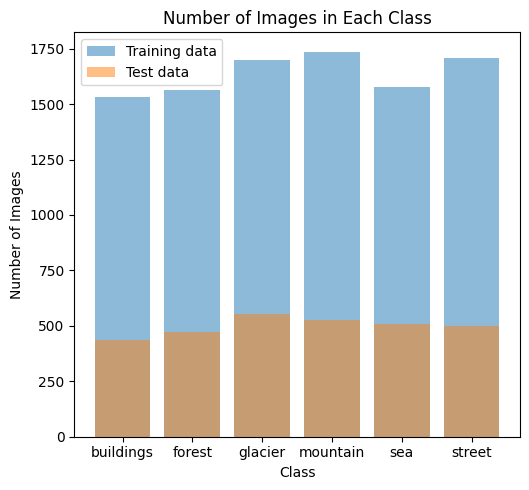

In [5]:
# plot the number if images in each class in the training and test data
labels = {0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(*np.unique(y_train, return_counts=True), label='Training data', alpha=0.5)
plt.bar(*np.unique(y_test, return_counts=True), label='Test data', alpha=0.5)
plt.title('Number of Images in Each Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(range(len(labels)), labels.values())  # Set the x-axis tick labels
plt.legend()
plt.tight_layout()
plt.show()


## Show Data

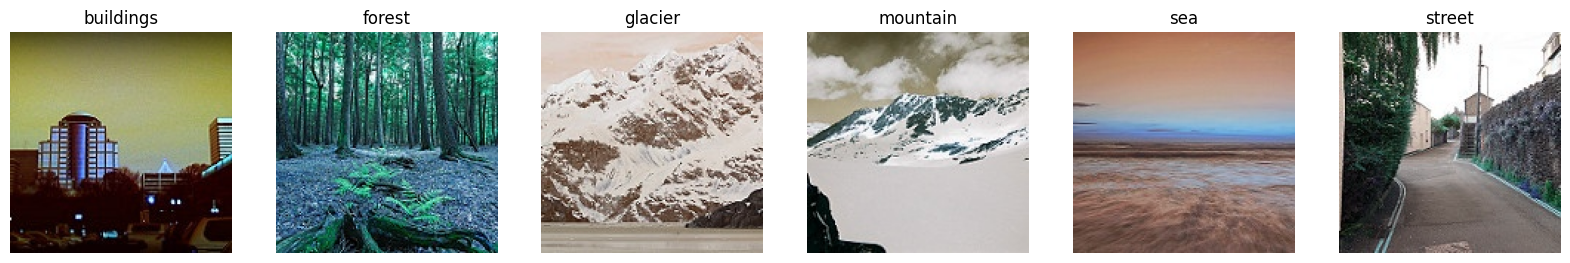

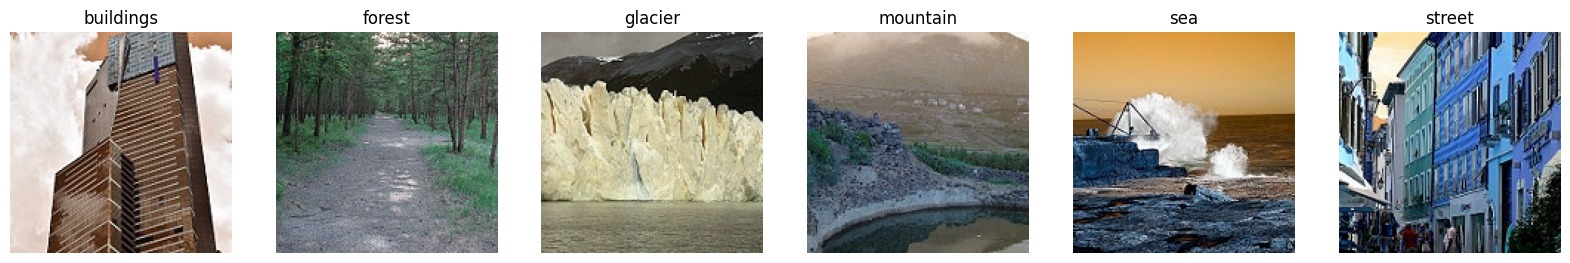

In [6]:
# display some images from the training data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_train[y_train == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

# display some images from the test data per class
fig, axes = plt.subplots(1, 6, figsize=(20, 20))
for i in range(6):
    axes[i].imshow(X_test[y_test == i][0])
    axes[i].set_title(labels[i])
    axes[i].axis('off')
plt.show()

## Split Training and Validation Data

In [8]:
# one-hot encode the labels
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# split the training data into training and validation data
# 80% of the data will be used for training and 20% for validation
# split the data stratified by the labels
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

## Normalize Data

In [9]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0


## Model Architecture

In [9]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))

model.add(Dense(6, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 82944)             0         
                                                                 
 dense (Dense)               (None, 64)                5

## Train Model

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/10
246/246 [==============================] - 16s 33ms/step - loss: 1.1883 - accuracy: 0.5480 - val_loss: 0.8598 - val_accuracy: 0.6728
Epoch 2/10
246/246 [==============================] - 5s 21ms/step - loss: 0.7722 - accuracy: 0.7149 - val_loss: 0.7506 - val_accuracy: 0.7308
Epoch 3/10
246/246 [==============================] - 5s 21ms/step - loss: 0.5400 - accuracy: 0.8133 - val_loss: 0.7344 - val_accuracy: 0.7354
Epoch 4/10
246/246 [==============================] - 5s 21ms/step - loss: 0.3748 - accuracy: 0.8719 - val_loss: 0.7386 - val_accuracy: 0.7542
Epoch 5/10
246/246 [==============================] - 5s 22ms/step - loss: 0.2148 - accuracy: 0.9295 - val_loss: 0.8775 - val_accuracy: 0.7349
Epoch 6/10
246/246 [==============================] - 5s 22ms/step - loss: 0.1054 - accuracy: 0.9719 - val_loss: 1.0916 - val_accuracy: 0.7318
Epoch 7/10
246/246 [==============================] - 5s 22ms/step - loss: 0.0593 - accuracy: 0.9860 - val_loss: 1.0079 - val_accuracy: 0.758

In [ ]:
# get the accuracy of the model

_, test_acc = model.evaluate(X_test, y_test, verbose=0)


print('Test accuracy:', test_acc)

Test accuracy: 0.7136666774749756


## Save Model

In [15]:
model.save('cnn1.h5')

## Version 2

In [16]:
model = Sequential()

model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 150, 150, 128)     9728      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 75, 75, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                      

In [17]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), callbacks=[reduce_lr], verbose=2)

Epoch 1/30
246/246 - 20s - loss: 1.6018 - accuracy: 0.5392 - val_loss: 3.9317 - val_accuracy: 0.3252 - lr: 0.0010 - 20s/epoch - 80ms/step
Epoch 2/30
246/246 - 14s - loss: 0.9727 - accuracy: 0.6452 - val_loss: 1.2669 - val_accuracy: 0.5501 - lr: 0.0010 - 14s/epoch - 58ms/step
Epoch 3/30
246/246 - 14s - loss: 0.8341 - accuracy: 0.6908 - val_loss: 1.2059 - val_accuracy: 0.6397 - lr: 0.0010 - 14s/epoch - 59ms/step
Epoch 4/30
246/246 - 14s - loss: 0.7200 - accuracy: 0.7322 - val_loss: 1.0157 - val_accuracy: 0.6387 - lr: 0.0010 - 14s/epoch - 59ms/step
Epoch 5/30
246/246 - 15s - loss: 0.6612 - accuracy: 0.7586 - val_loss: 2.8307 - val_accuracy: 0.4723 - lr: 0.0010 - 15s/epoch - 59ms/step
Epoch 6/30
246/246 - 15s - loss: 0.5732 - accuracy: 0.7941 - val_loss: 0.8357 - val_accuracy: 0.6972 - lr: 0.0010 - 15s/epoch - 59ms/step
Epoch 7/30
246/246 - 15s - loss: 0.4916 - accuracy: 0.8271 - val_loss: 1.3793 - val_accuracy: 0.5929 - lr: 0.0010 - 15s/epoch - 59ms/step
Epoch 8/30
246/246 - 15s - loss: 0

In [18]:
# get the accuracy of the model
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.8339999914169312


In [19]:
model.save('cnn2.h5')

## Version 3

In [10]:
model = Sequential()

model.add(Conv2D(128, (5, 5), activation='relu', input_shape=(150, 150, 3), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(6, activation='softmax'))

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 128)     9728      
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        73792     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range = 0.1, # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False # randomly flip images
)

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.5, min_lr=0.00001)
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val), callbacks=[reduce_lr])

Epoch 1/20
246/246 [==============================] - 46s 157ms/step - loss: 1.8317 - accuracy: 0.5322 - val_loss: 2.6819 - val_accuracy: 0.4036 - lr: 0.0010
Epoch 2/20
246/246 [==============================] - 37s 152ms/step - loss: 0.9882 - accuracy: 0.6323 - val_loss: 5.0841 - val_accuracy: 0.2997 - lr: 0.0010
Epoch 3/20
246/246 [==============================] - 37s 149ms/step - loss: 0.8767 - accuracy: 0.6843 - val_loss: 1.0047 - val_accuracy: 0.6295 - lr: 0.0010
Epoch 4/20
246/246 [==============================] - 38s 155ms/step - loss: 0.8300 - accuracy: 0.6910 - val_loss: 0.9022 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 5/20
246/246 [==============================] - 39s 157ms/step - loss: 0.7594 - accuracy: 0.7252 - val_loss: 1.0598 - val_accuracy: 0.5791 - lr: 0.0010
Epoch 6/20
246/246 [==============================] - 39s 157ms/step - loss: 0.7309 - accuracy: 0.7334 - val_loss: 0.7519 - val_accuracy: 0.7160 - lr: 0.0010
Epoch 7/20
246/246 [==============================] 

In [12]:
# get the accuracy of the model
_, test_acc = model.evaluate(X_test, y_test, verbose=0)

print('Test accuracy:', test_acc)

Test accuracy: 0.8529999852180481


In [13]:
model.save('cnn3.h5')